# キオクシアホールディング 日足

In [1]:
import sys
sys.path.append('..')

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [2]:
pattern = re.compile(r'(.+)\.T')

symbol = '285A.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='1mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-26 00:00:00+09:00,2602.0,2622.0,2451.0,2539.0,15478500,0.0,0.0
2025-02-27 00:00:00+09:00,2620.0,2847.0,2620.0,2805.0,22988500,0.0,0.0
2025-02-28 00:00:00+09:00,2705.0,2775.0,2482.0,2670.0,18510500,0.0,0.0
2025-03-03 00:00:00+09:00,2800.0,2823.0,2482.0,2482.0,20308600,0.0,0.0
2025-03-04 00:00:00+09:00,2400.0,2504.0,2321.0,2448.0,10764900,0.0,0.0
2025-03-05 00:00:00+09:00,2466.0,2527.0,2372.0,2431.0,7835800,0.0,0.0
2025-03-06 00:00:00+09:00,2481.0,2490.0,2368.0,2388.0,5953200,0.0,0.0
2025-03-07 00:00:00+09:00,2338.0,2798.0,2330.0,2790.0,33199900,0.0,0.0
2025-03-10 00:00:00+09:00,2733.0,2783.0,2547.0,2754.0,20193100,0.0,0.0


## 日足チャートとパラボリック SAR

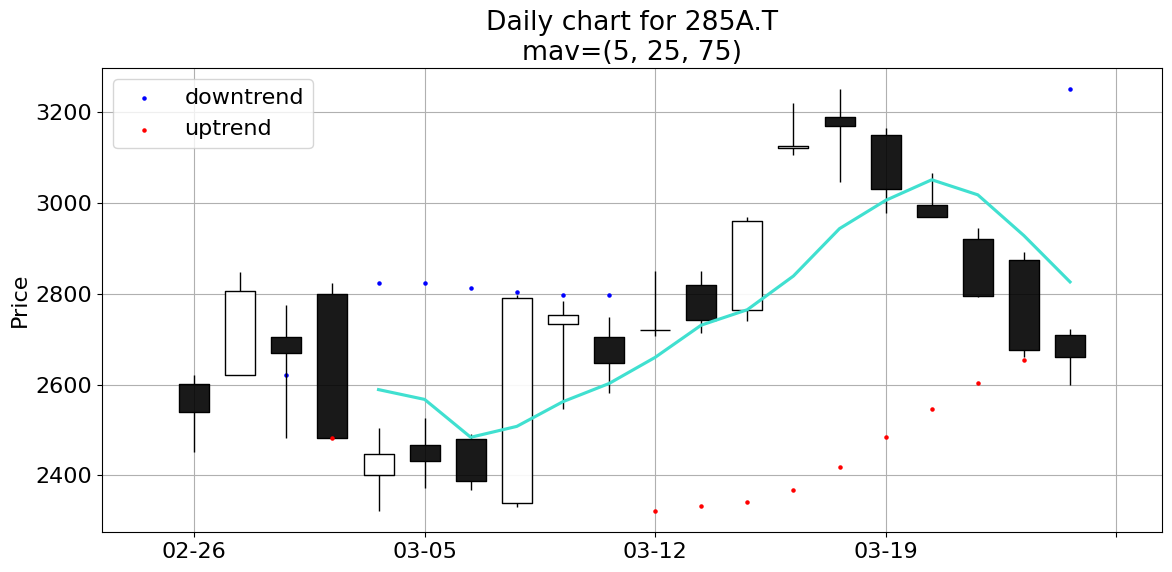

In [3]:
dict_psar = psar(df)

plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()
#ax.legend(loc='best')

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-03-25 00:00:00+09:00    2676.0
2025-03-26 00:00:00+09:00    2660.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-03-25 00:00:00+09:00     NaN
2025-03-26 00:00:00+09:00   -16.0
Name: Close, dtype: float64